Having another look at the COS lightcurve with better code

In [1]:
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import calcos
import costools
import lightkurve as lk
from astropy.convolution import convolve, Box1DKernel

#from costools import splittag

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


In [2]:
path = '/media/david/1tb_storage1/emergency_data/cc_cet/hst/'
dpath = '{}data/'.format(path)

In [3]:
tags = glob.glob('{}*corrtag*.fits'.format(dpath))
# tags

In [4]:
tagpath = '{}tagfiles/'.format(path)
tbin =10
# for tag in tags:
#     rootname = fits.getheader(tag,0)['ROOTNAME']
#     costools.splittag.splittag(tag, '{}{}_split{}s'.format(tagpath, rootname, tbin), increment=tbin)

In [5]:
newtags = glob.glob('{}*{}s*corrtag_a*'.format(tagpath, tbin))
# newtags
print(len(newtags))

378


In [6]:
os.environ['lref'] = dpath

In [7]:
outpath = '{}/output/'.format(path)
# for tag in newtags[374:]:
#     calcos.calcos(tag, outdir=outpath, verbosity=1)

In [8]:
# costools.x1dcorr.help()

In [9]:
newx1ds = glob.glob('{}*{}s*x1d.fits'.format(outpath,tbin))
print(len(newx1ds))
# print(newx1ds[0])

376


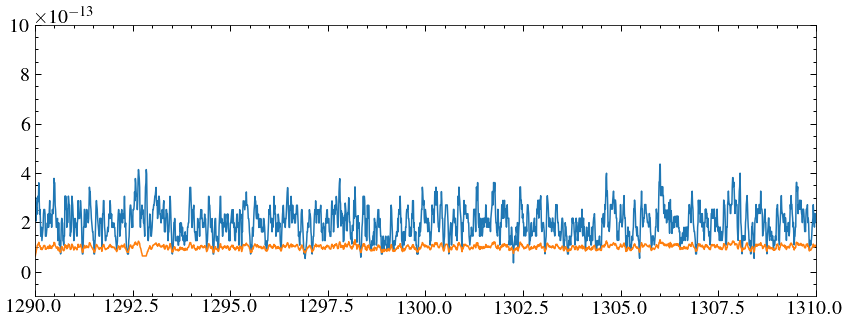

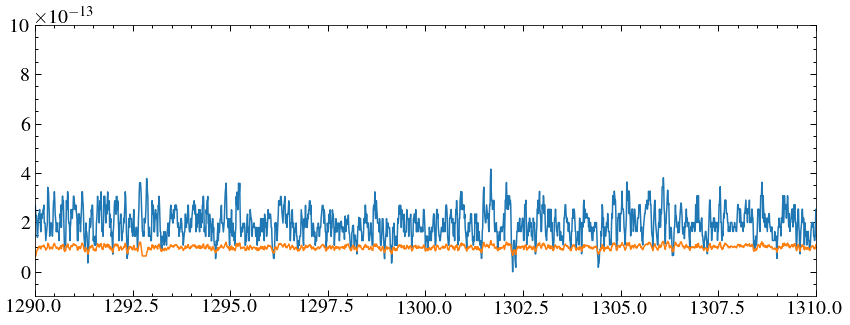

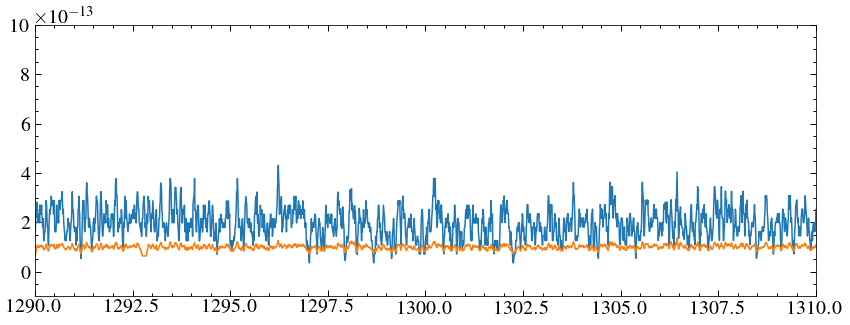

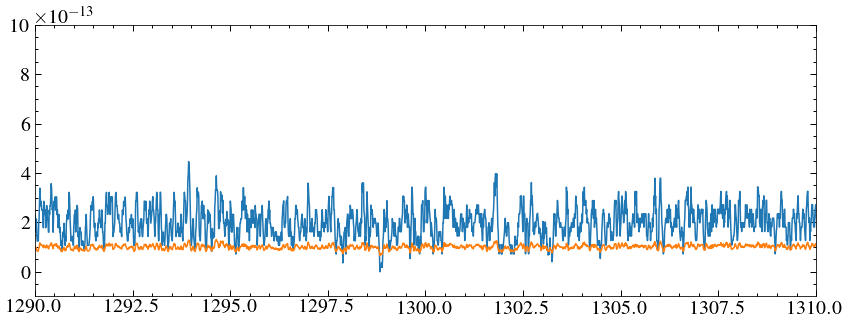

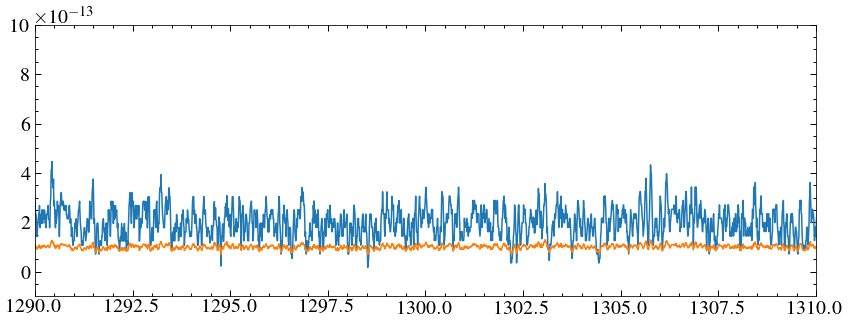

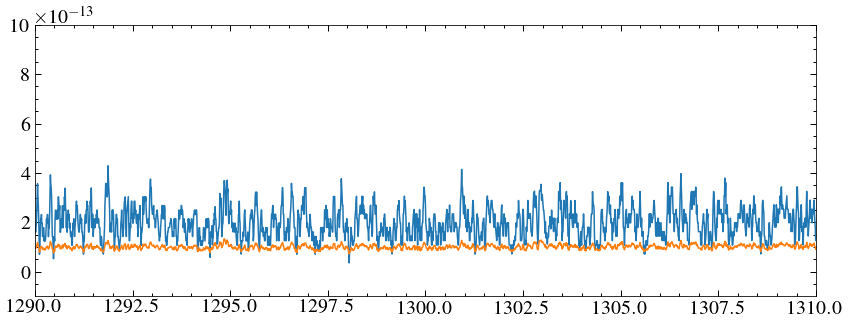

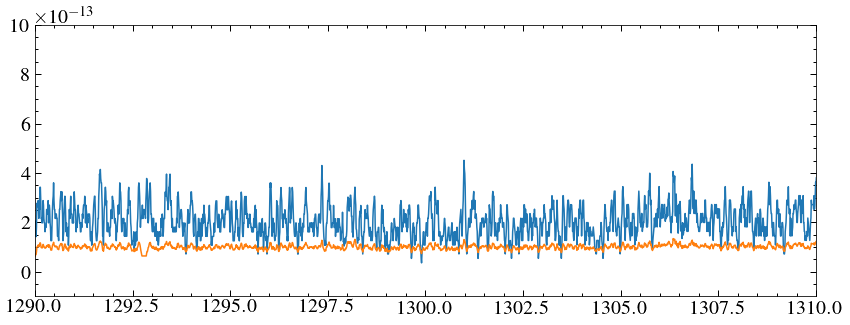

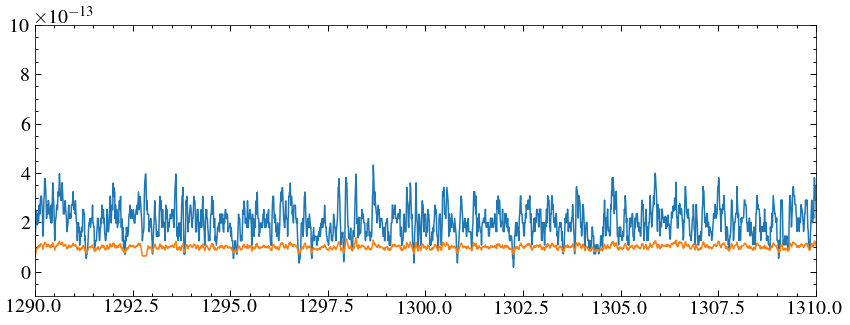

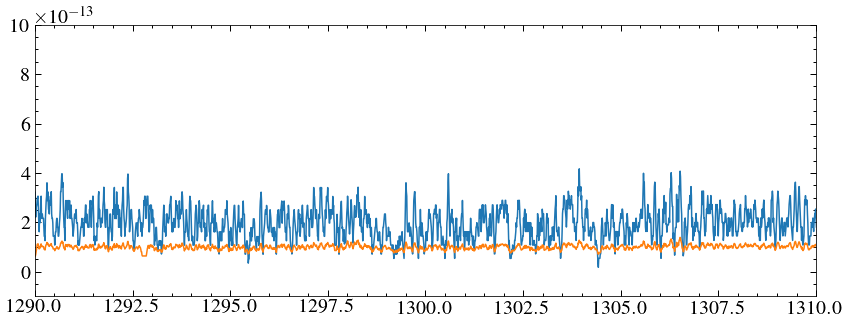

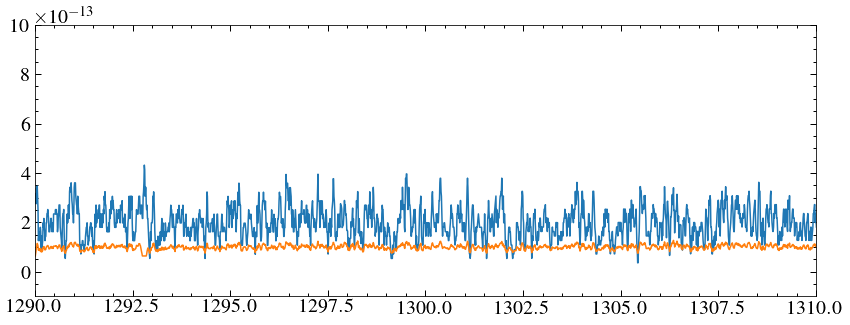

In [34]:
si4 = [1393.775,1402.770]

smooth=5
for x in newx1ds[0:10]:
    data = fits.getdata(x, 1)
    for dt in data:
        w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
        mask = (dq == 0) & (w < 1900)
#         w, f, e = w[mask], f[mask], e[mask]
        f = convolve(f,Box1DKernel(smooth))
        e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
        plt.plot(w, f)
        plt.plot(w, e)
#     plt.xlim(1390,1410)
    plt.xlim(1290, 1310)
    plt.ylim(-1e-13, 1e-12)
    [plt.axvline(line, ls='--', c='C2') for line in si4]
    plt.show()

In [11]:
# fits.getheader(x,1)

In [12]:
# for i, x in enumerate(newx1ds):
# #     hdr= fits.getheader(x, 1)
# #     print() 
# #     print(hdr['EXPSTRTJ'], hdr['EXPENDJ'], hdr['EXPTIME'])
# #     plt.scatter(i, hdr['EXPENDJ'])
#     rootname = fits.getheader(tag,0)['ROOTNAME']
#     print('{}{}_{}')

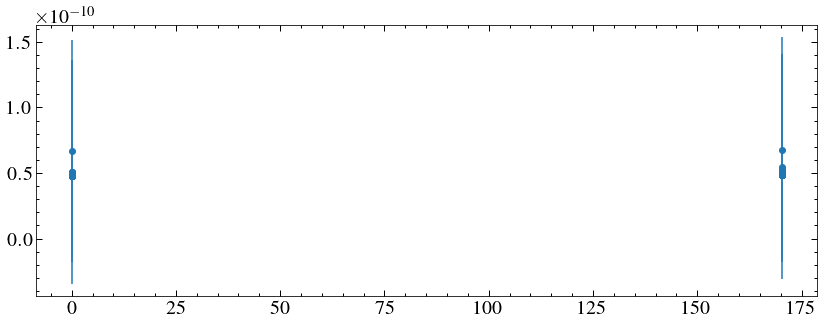

In [26]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1


band = [1250, 1700] #pick the wavelength range to integrate.
time = [] #arrays to put the light curve in
flux = []
error = []
counts = []
roots = []
for x in newx1ds:
    hdul = fits.open(x)
    hdr = hdul[1].header
    data = hdul[1].data
    hdul.close()
    ti = hdr['EXPENDJ'] - ((hdr['EXPTIME']*u.s).to(u.d).value)/2
    time.append(ti)
    roots.append(hdr['ROOTNAME'])
    fis = []
    eis = []
    cis = []
    for dt in data:
        w, f, e, c, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['NET'],dt['DQ']
        w0, w1 = wavelength_edges(w) 
        mask = (dq == 0) & (w > 1210) | (w < 1220) & (dq==0)
        w0, w1, f, e, c = w0[mask], w1[mask], f[mask], e[mask],c[mask]
        fi = np.sum(f*(w1-w0))
        ci = np.sum(c*(w1-w0))
        ei = (np.sum(e**2 * (w1-w0)**2))**0.5
        fis.append(fi)
        eis.append(ei)
        cis.append(ci)
    flux.append(np.sum(np.array(fis)))
    counts.append(np.sum(np.array(cis)))
    error.append(np.sum(np.array(eis)**2)**0.5)
    
time, flux, error, counts, roots = np.array(time), np.array(flux), np.array(error), np.array(counts), np.array(roots)
args = np.argsort(time)


alltime, allflux, allerror, allcounts, allroots = np.array(time[args]), np.array(flux[args]), np.array(error[args]), np.array(counts[args]), np.array(roots[args])

t0 = min(time)
plt.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
# plt.ylabel('Counts (s$^{-1})$')
# plt.xlabel('Time (MJD-{})'.format(t0))
plt.show()    

In [27]:
# nf = flux/np.median(flux)
# ne = error/np.median(flux)
# nc = counts/np.median(counts)
# nce = (np.sqrt(counts*tbin)/(tbin))/np.median(counts)
# # plt.scatter(time, nf)
# plt.errorbar(time-t0, nf, yerr = ne, marker='o', ls='none') #plot the light curve
# plt.errorbar(time-t0, nc, yerr = nce, marker='o', ls='none') #plot the light curve
# # plt.errorbar(time, nf, yerr = ne, ls='none', c='C1') #plot the light curve
# # plt.ylim(0, 1.3)p
# plt.xlim(-0.1, 0.1)

In [28]:
# lc = lk.LightCurve(time=time, flux=nf, flux_err=ne)

In [29]:
# pg=lc.to_periodogram(oversample_factor=10, minimum_period=20*u.s, maximum_period=900*u.s)
# plt.plot(pg.period.to(u.s), pg.power)

Separate into two light curves, then normalize each fppos separatetly. 

In [17]:
# print(np.unique(allroots))

537.4960586428642
430.0000414252281
429.99992072582245
430.0000011920929


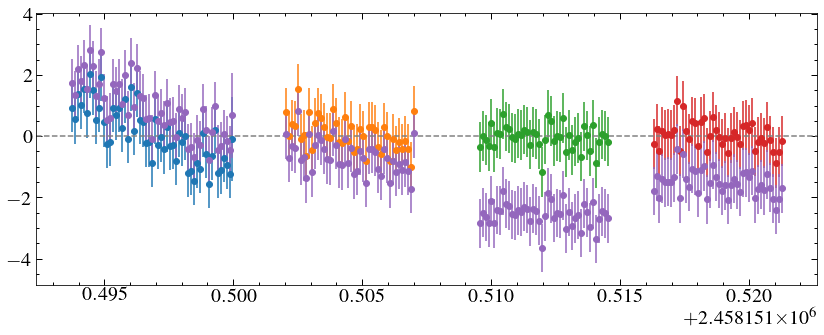

668.6996490508722 s
895.0260586259434 s


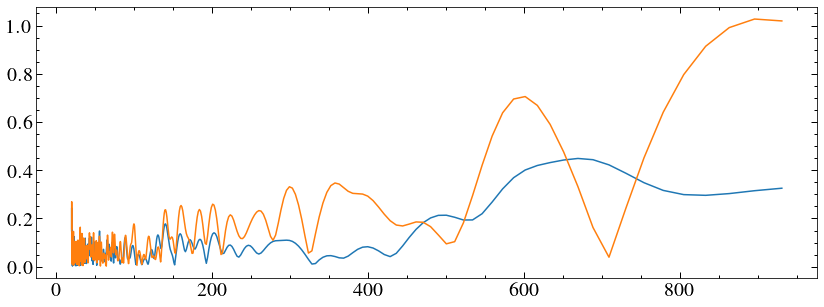

537.5119909644127
430.0000011920929
430.0000414252281
429.99992072582245


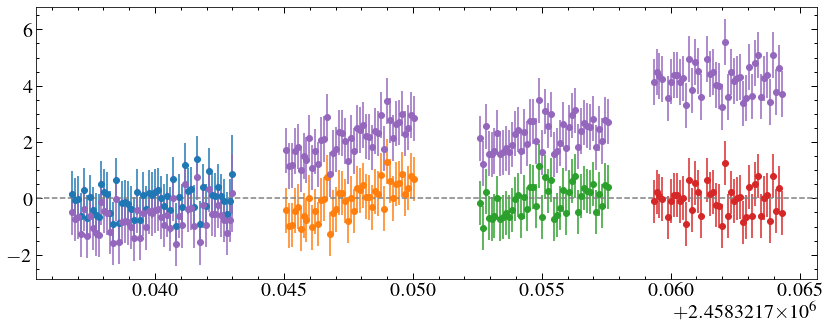

668.6996426986161 s
804.287059482994 s


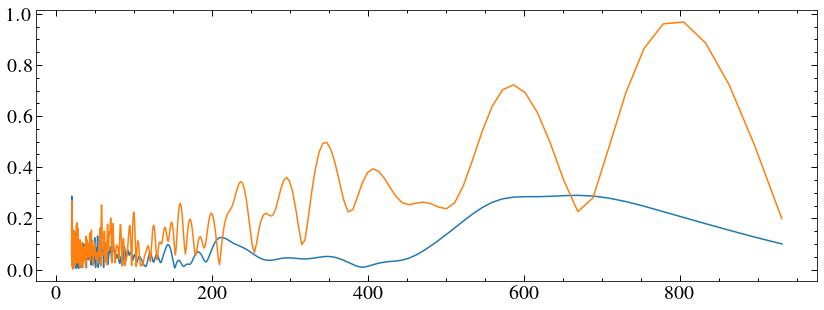

In [39]:
obsroots = ['ldlc01', 'ldlc51']
allproots = np.unique(allroots)
proot_collections = [allproots[0:4], allproots[4:]]
# print(proot_collections)
# for obsroot in obsroots[0]:
#     mask = ([r[0:8] == obsroot for r in allroots])
#     rt, rf, re,rr = alltime[mask], allflux[mask], allerror[mask], allroots[mask]
nf, ne = allflux/np.median(allflux), allerror/np.median(allflux)
for i, proots in enumerate(proot_collections):
    otime = np.array([], dtype=float)
    oflux = np.array([], dtype=float)
    oerror = np.array([], dtype=float)
    ocounts = np.array([], dtype=float)
    for proot in proots:
        mask = (allroots == proot) & ((allflux/allerror) > 1)
        pt, pf, pe, pc = alltime[mask], allflux[mask], allerror[mask], allcounts[mask]
        print((max(pt)-min(pt))*u.d.to(u.s))
    #     plt.errorbar(pt, pf, yerr = pe, marker='o', ls='none')
        pfn, pen = pf/np.median(pf), pe/np.median(pf)
        pfn -=1
        pfn, pen = pfn*100, pen*100
        plt.errorbar(pt, pfn, yerr = pen, marker='o', ls='none')
        otime= np.concatenate((otime, pt))
        oflux= np.concatenate((oflux, pfn))
        oerror= np.concatenate((oerror, pen))
        ocounts= np.concatenate((ocounts, pc))
    
    
    savdat = Table([otime, oflux, oerror], names=['JD', 'FLUX', 'FLUX_ERROR'])
    ascii.write(savdat, 'lightcurves/cc__cos_{}_{}s_fppos_norm.ecsv'.format(obsroots[i],tbin), format='ecsv', overwrite=True)
      

    pt0 = np.min(otime)
    mask2 = (allroots == proots[0]) | (allroots == proots[1])| (allroots == proots[2])| (allroots == proots[3])
    
    t2, nf2, ne2 = alltime[mask2], nf[mask2], ne[mask2]
    mask3 = (nf2/ne2 > 1)
    t2, nf2, ne2 = t2[mask3], nf2[mask3], ne2[mask3]
    nf2 = nf2-1
    nf2, ne2= nf2*100, ne2*100
    plt.errorbar(t2, nf2, yerr = ne2, marker='o', ls='none')
    plt.axhline(0, ls='--', c='0.5')
    plt.show()
    lc1 = lk.LightCurve(time=otime-pt0, flux=oflux, flux_err=oerror)
    pg1=lc1.to_periodogram(oversample_factor=10, minimum_period=20*u.s, maximum_period=930*u.s)
    lc2 = lk.LightCurve(time=t2-pt0, flux=nf2, flux_err=ne2)
    pg2= lc2.to_periodogram(oversample_factor=10, minimum_period=20*u.s, maximum_period=930*u.s)
    print(pg1.period_at_max_power.to(u.s))
    print(pg2.period_at_max_power.to(u.s))

    
    plt.plot(pg1.period.to(u.s), pg1.power)
    plt.plot(pg2.period.to(u.s), pg2.power)
    
   
    
    
    plt.show()
        

In [32]:
counts_error = np.sqrt(allcounts*tbin)/tbin
savdat = Table([alltime, allflux, allerror, allcounts, counts_error, allroots], names=['JD', 'FLUX', 'FLUX_ERROR', 'COUNTS', 'COUNTS_ERROR', 'ROOTNAME'])
ascii.write(savdat, 'lightcurves/cc_cet_cos_{}s.ecsv'.format(tbin), format='ecsv', overwrite=True)